In [5]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn import covariance

%matplotlib widget

def calculate_condition_number(X,estimator=covariance.MinCovDet):
    C = estimator().fit(X)
    cov = pd.DataFrame(C.covariance_,index=X.columns,columns=X.columns)
    D,L = linalg.eig(cov)
    cond_number = D.max() / D.min()
    return cond_number,cov


# Rank co-correlates
def print_top_cocorrelates(cov,num2print=50):
    cov_no_diag = cov.values
    cov_no_diag[np.eye(len(cov)).astype(bool)] = np.nan
    cov_no_diag[np.triu(np.ones(len(cov))).astype(bool)] = np.nan
    cov_no_diag = pd.DataFrame(cov_no_diag,index=cov.index,columns=cov.columns)
    return cov_no_diag.stack().dropna().abs().sort_values().tail(num2print)
    

In [6]:
# Load data
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/'

all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'duration' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Manual' in f]
# features2drop += [(f,a) for f,a in divisions.columns if 'Height to BM' in f]
# features2drop += [(f,a) for f,a in divisions.columns if 'Basal area' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))

# Load images
from skimage import io
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_72915/1139098687.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)


668


In [38]:
np.diff(importances.sort_values(by='RF_imp')['RF_imp'])

array([1.95182071e-05, 5.15167005e-06, 2.29582086e-05, ...,
       1.76654203e-03, 1.18559248e-03, 3.26644863e-03])

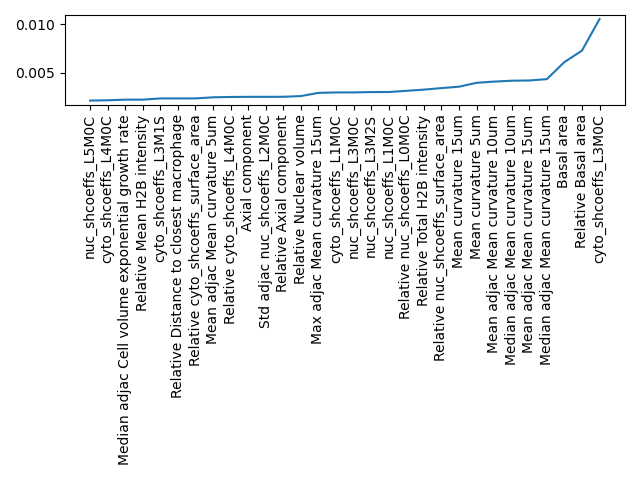

In [107]:
feature2predict = 'At least one daughter differentiated'
_df = divisions.dropna(subset=[(feature2predict,'Meta')])

y = _df[feature2predict,'Meta']
X = _df.xs('Measurement',level=1,axis=1)
import statsmodels
from sklearn import preprocessing

# Take top 50 features by importance and see their correlation matrix
importances = pd.read_csv(path.join(model_dir,'Random_forest_division/importances.csv'),
                         index_col=0)
importances = importances.rename(columns={'0':'RF_imp'})

plt.close('all')
plt.figure()
plt.plot(importances.sort_values(by='RF_imp')['RF_imp'][-30:] )
# plt.vlines(x=2,ymin=0,ymax=0.01,color='r')
plt.xticks(rotation=90)
plt.tight_layout()

In [108]:
important_features = importances.sort_values(by='RF_imp').tail(20).index

X = X[important_features]
X = X.dropna(axis=1)
important_features = X.columns
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns= important_features)
print(important_features)

Index(['Std adjac nuc_shcoeffs_L2M0C', 'Relative Axial component',
       'Relative Nuclear volume', 'Max adjac Mean curvature 15um',
       'cyto_shcoeffs_L1M0C', 'nuc_shcoeffs_L3M0C', 'nuc_shcoeffs_L3M2S',
       'nuc_shcoeffs_L1M0C', 'Relative nuc_shcoeffs_L0M0C',
       'Relative Total H2B intensity', 'Relative nuc_shcoeffs_surface_area',
       'Mean curvature 15um', 'Mean curvature 5um',
       'Mean adjac Mean curvature 10um', 'Median adjac Mean curvature 10um',
       'Mean adjac Mean curvature 15um', 'Median adjac Mean curvature 15um',
       'Basal area', 'Relative Basal area', 'cyto_shcoeffs_L3M0C'],
      dtype='object', name='Name')


(20, 20)
Condition number: 1359.3676370793082


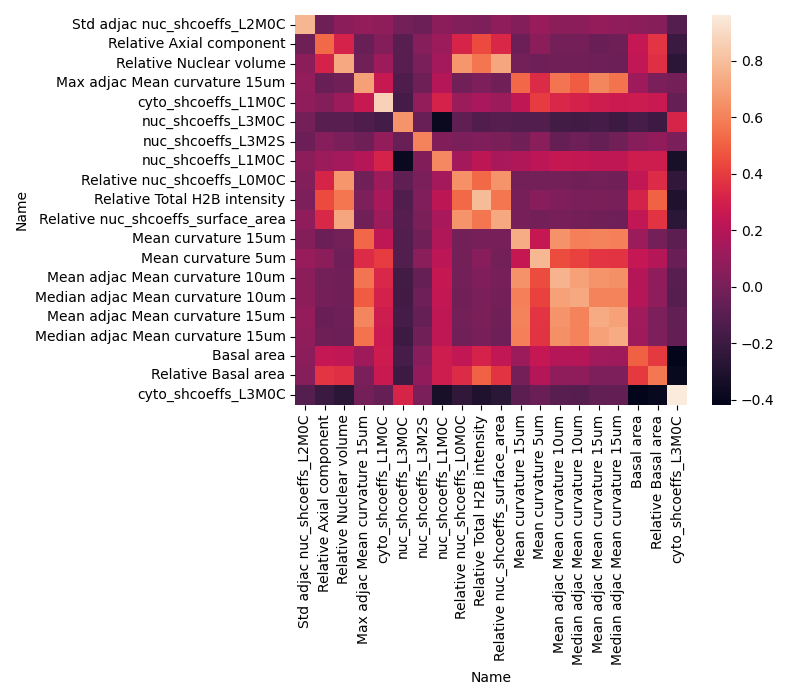

In [109]:
# Calculate the condition number
from numpy import linalg

plt.figure(figsize=(8,7))
cond_num, cov = calculate_condition_number(X_scaled)
sb.heatmap(cov)
plt.tight_layout()
print(cov.shape)

D,L = linalg.eig(cov)
print(f'Condition number: {cond_num}')

# print_top_cocorrelates(cov)

11.844050654442274


Name                           Name                         
Max adjac Mean curvature 15um  Relative Axial component         0.002600
Mean curvature 15um            Relative Axial component         0.012053
Mean curvature 5um             Relative Nuclear volume          0.025809
Relative Basal area            Mean curvature 15um              0.037576
                               Max adjac Mean curvature 15um    0.051913
Mean curvature 15um            Relative Nuclear volume          0.075314
Max adjac Mean curvature 15um  Relative Nuclear volume          0.083961
Mean curvature 5um             Relative Axial component         0.094442
Relative Basal area            Mean curvature 5um               0.192071
Mean curvature 5um             Mean curvature 15um              0.221617
                               Max adjac Mean curvature 15um    0.351441
Relative Nuclear volume        Relative Axial component         0.357140
Relative Basal area            Relative Nuclear volume         

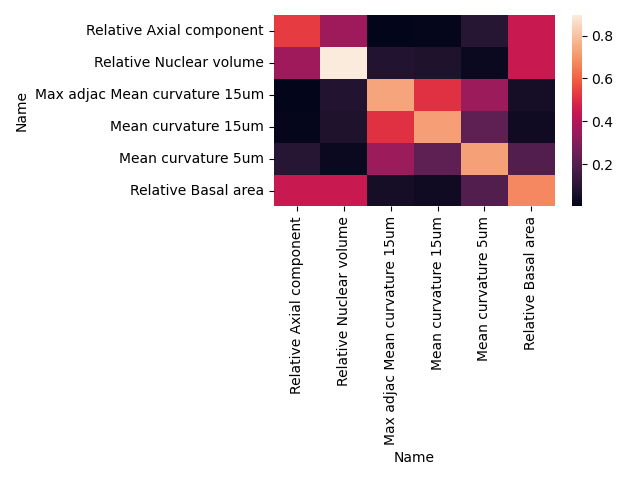

In [116]:
# Eliminate covarying features

features2keep = important_features.drop(['Basal area',
                                        'Median adjac Mean curvature 15um',
                                        'Mean adjac Mean curvature 15um',
                                        'Median adjac Mean curvature 10um',
                                        'Mean adjac Mean curvature 10um',
                                         'Relative Total H2B intensity',
                                         'Relative nuc_shcoeffs_surface_area',]
                                       +[f for f in important_features if 'shcoeff' in f])
# features2keep = ['Relative Basal area','Mean curvature 5um','Relative Nuclear volume',
#                 'Std adjac nuc_shcoeffs_L2M0C']
# features2keep = important_features

cond_num, cov_ = calculate_condition_number(X_scaled[features2keep])
print(cond_num)
X_ = X_scaled[features2keep]
plt.close('all')
plt.figure()
sb.heatmap(cov_)
plt.tight_layout()

print_top_cocorrelates(cov_,num2print=20)
# cov_

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.46195314875530835
            Iterations: 81
            Function evaluations: 81
            Gradient evaluations: 81
                               Effect size         pvals      -LogP
Relative Nuclear volume          -0.152464  3.651631e-01   0.437513
Mean curvature 5um               -0.200438  3.117947e-01   0.506131
Relative Basal area              -0.235902  2.500364e-01   0.601997
Max adjac Mean curvature 15um    -0.283059  7.127340e-02   1.147073
Mean curvature 15um              -0.403745  5.708489e-02   1.243479
constant                         -0.549654  7.423577e-03   2.129387
Relative Axial component          1.466616  1.134790e-17  16.945085


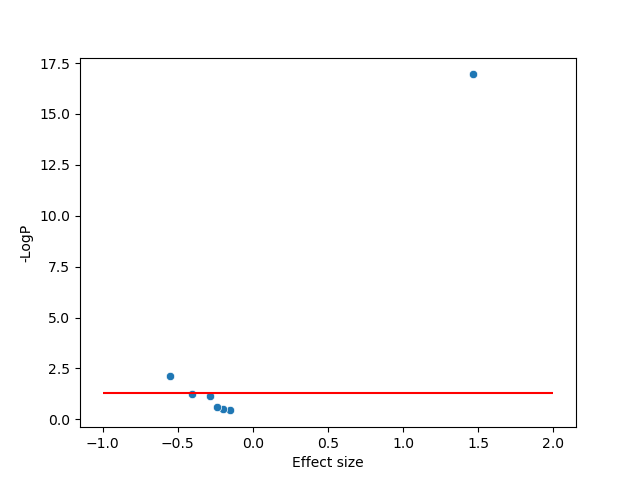

In [117]:
# Regularization
from statsmodels.api import Logit
from statsmodels.base.elastic_net import RegularizedResults
from statsmodels.tools import tools

X_ = tools.add_constant(X_)
X_ = np.asarray(X_).astype(float)
y_ = np.asarray(y).astype(bool)

model = Logit(endog = y_,exog = X_).fit_regularized(alpha = 0.01, solver='l1_cvxopt_cp')
# elastinet = RegularizedResults(model
params = pd.DataFrame(model.params,index=list(features2keep)+['constant'],columns=['Effect size'])
params['pvals'] = model.pvalues
params['-LogP'] = -np.log10(model.pvalues)
print(params.sort_values(by='-LogP'))
plt.figure()
sb.scatterplot(params,x='Effect size',y='-LogP')
plt.hlines(-np.log10(0.05),xmin=-1,xmax=2,color='r')


<Axes: xlabel='Mean curvature 5um'>

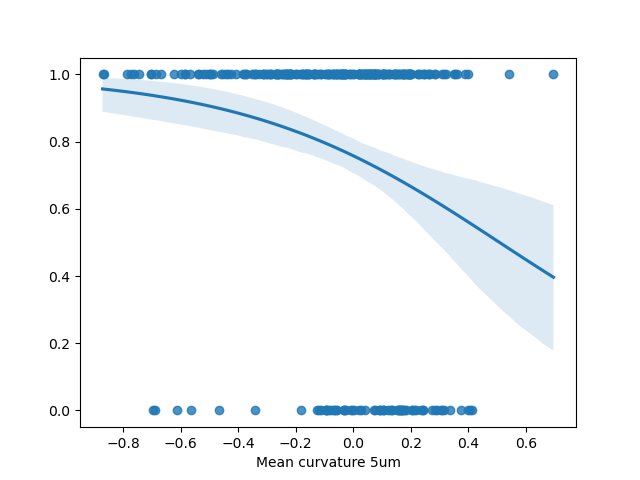

In [119]:
plt.figure()
sb.regplot(y=y_,x=X['Mean curvature 5um'],logistic=True)
# sb.regplot(y=X['Relative Basal area'],x=X['cyto_shcoeffs_L1M0C'],logistic=False)


# PCA

In [122]:
model_dir

'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/'

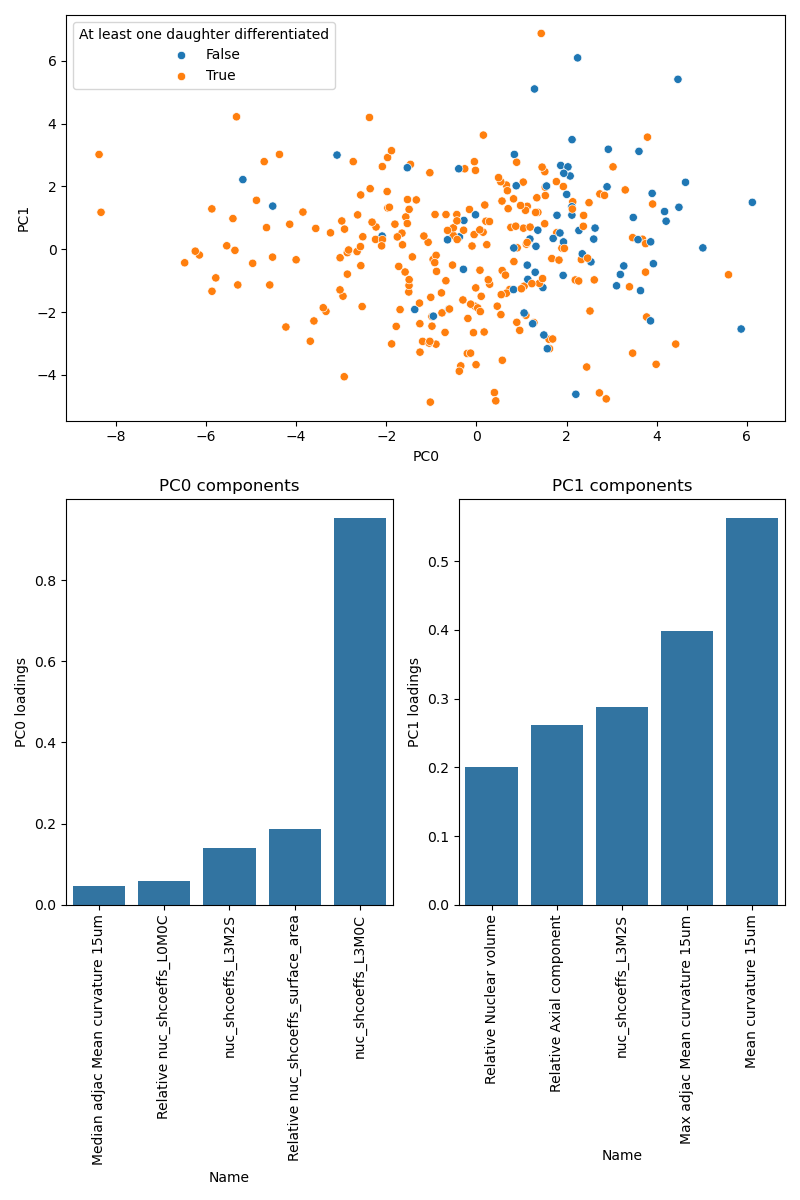

In [123]:
from sklearn import decomposition
pca = decomposition.PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_scaled),index=X_scaled.index)

var_explained = pd.Series(pca.explained_variance_)
# X_pca = pd.
X_pca[feature2predict] = y

loadings = pd.DataFrame(pca.components_,index=X_scaled.columns)
loadings[1].abs().sort_values()

plt.close('all')
fig = plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
sb.scatterplot(X_pca,x=0,y=1,hue=feature2predict)
plt.xlabel('PC0'); plt.ylabel('PC1')

plt.subplot(2,2,3)
sb.barplot(loadings[0].sort_values().tail(5))
plt.ylabel('PC0 loadings')
plt.xticks(rotation=90)
plt.title('PC0 components')

ax= plt.subplot(2,2,4)
sb.barplot(loadings[1].sort_values().tail(5))
plt.ylabel('PC1 loadings')
plt.xticks(rotation=90)
plt.title('PC1 components')
plt.tight_layout()

fig.savefig(path.join(model_dir,'Linear_model_division/PCA_top20_fate_colored.svg'))

In [101]:
X_scaled.sort_values(by='nuc_shcoeffs_L3M0C').tail(10)

,Name,Std adjac nuc_shcoeffs_L2M0C,Relative Axial component,Relative Nuclear volume,Max adjac Mean curvature 15um,cyto_shcoeffs_L1M0C,nuc_shcoeffs_L3M0C,nuc_shcoeffs_L3M2S,nuc_shcoeffs_L1M0C,Relative nuc_shcoeffs_L0M0C,Relative Total H2B intensity,Relative nuc_shcoeffs_surface_area,Mean curvature 15um,Mean curvature 5um,Mean adjac Mean curvature 10um,Median adjac Mean curvature 10um,Mean adjac Mean curvature 15um,Median adjac Mean curvature 15um,Basal area,Relative Basal area,cyto_shcoeffs_L3M0C
Frame,TrackID,,,,,,,,,,,,,,,,,,,,
7,R2_941,-0.346975,0.394006,-1.436882,1.503881,0.076695,2.112746,-4.531167,-4.932054,-2.084373,1.101270,-1.456990,1.496422,0.823453,1.485846,0.814790,1.414059,1.269880,1.622081,0.512480,-0.510908
8,R2_813,-0.148746,-0.910437,0.806826,2.577599,-0.569287,2.282712,1.294932,-0.187487,0.920488,-0.122128,0.840795,0.758480,1.709816,0.867130,2.665919,1.399196,1.502006,-2.943787,-2.714066,3.383150
7,R2_1088,0.517153,0.325195,1.173143,0.731317,-0.854429,2.443230,-1.394688,0.628932,1.283573,0.986614,1.190030,0.898505,-0.806290,0.872272,0.976348,0.544087,0.773576,1.810126,0.330845,0.298199
4,R2_888,0.159012,0.952867,-0.908887,1.889057,1.386606,2.492937,-0.964669,-2.121813,-0.871336,1.247157,-0.941355,-0.344999,0.752006,0.396602,0.876339,0.487663,0.311516,-0.001045,-0.185995,1.625711
1,R1_47,0.227846,0.992765,-1.427513,-0.814145,-0.842448,2.511729,2.046418,-0.009373,-1.288025,0.307148,-1.244860,-1.837319,-0.161282,-1.590834,-0.918976,-1.846195,-1.676523,0.698351,0.937918,0.746891
3,R1_902,-0.405805,1.011611,-2.800623,-1.147463,1.265742,2.798947,-0.445163,-2.627880,-3.008722,-0.437615,-2.957378,-0.017350,-1.663661,-0.439238,-0.657158,-1.311761,-1.430828,0.507007,0.586003,-0.344283
4,R2_94,-0.036025,0.554051,-2.121231,-1.745067,0.298066,2.967371,2.936683,-1.589163,-2.577925,0.503528,-2.095571,-2.078431,-1.430395,-1.689569,-1.792254,-1.900611,-2.017384,-0.740030,0.690726,-1.038029
3,R2_307,2.668077,0.424191,-1.368355,2.436448,0.545131,3.069957,-0.398899,-0.362208,-1.327812,1.863791,-1.291821,0.471254,1.675137,-0.728800,-2.103735,0.030554,-0.409595,-2.089336,-1.634441,0.689692
7,R2_845,-0.934897,0.414153,-1.847310,1.503881,-0.115033,3.361593,-3.018865,-0.287131,-2.285246,-0.191475,-1.505129,0.458140,0.250096,0.681970,0.805438,1.176828,1.071171,0.972171,-0.029473,1.059399


In [102]:
X_scaled.sort_values(by='nuc_shcoeffs_L3M0C').head(10)

Name           Std adjac nuc_shcoeffs_L2M0C  Relative Axial component  \
Frame TrackID                                                           
5     R2_740                       0.098559                  1.758877   
3     R2_208                       0.114834                  0.272715   
1     R2_734                       1.447276                  2.605811   
0     R1_209                       0.293147                  0.708552   
6     R1_278                       0.887027                  1.276509   
3     R1_785                      -0.307296                 -0.375681   
2     R1_887                      -0.660049                 -0.152025   
      R1_880                      -0.463580                  0.511081   
0     R2_401                       0.286342                 -0.339381   
1     R2_449                       1.423683                 -1.340140   

Name           Relative Nuclear volume  Max adjac Mean curvature 15um  \
Frame TrackID                                                           
5     R2_740                 -1.086834                      -0.678636   
3     R2_208                 -1.044733                      -0.992679   
1     R2_734                 -0.129835                      -0.169195   
0     R1_209                  1.130114                      -0.070610   
6     R1_278                  1.356813                       0.655524   
3     R1_785                 -0.246077                       0.870735   
2     R1_887                  1.415667                       0.344610   
      R1_880                  0.004287                       0.303175   
0     R2_401                  0.794375                      -0.460023   
1     R2_449                 -0.199409                       2.355454   

Name           cyto_shcoeffs_L1M0C  nuc_shcoeffs_L3M0C  nuc_shcoeffs_L3M2S  \
Frame TrackID                                                                
5     R2_740             -0.212807           -3.646320            1.070566   
3     R2_208             -3.362123           -2.710869            0.857381   
1     R2_734             -1.148373           -2.468270           -0.105125   
0     R1_209             -0.081034           -2.458902            0.814216   
6     R1_278              0.891743           -2.446066            0.963347   
3     R1_785              0.347851           -2.099706            0.375535   
2     R1_887              1.460098           -2.049131            0.356484   
      R1_880              0.910331           -1.990418            0.023826   
0     R2_401              0.755915           -1.825375           -1.132605   
1     R2_449              0.389451           -1.761448            0.440880   

Name           nuc_shcoeffs_L1M0C  Relative nuc_shcoeffs_L0M0C  \
Frame TrackID                                                    
5     R2_740            -0.639641                    -2.139802   
3     R2_208            -0.132264                    -2.891217   
1     R2_734            -1.660048                    -2.325256   
0     R1_209             2.096559                     0.788636   
6     R1_278            -4.321228                     0.789261   
3     R1_785             0.662456                    -0.096057   
2     R1_887             2.095667                     1.350796   
      R1_880            -0.387830                    -0.221820   
0     R2_401             1.941528                     0.561449   
1     R2_449             1.664379                    -0.215553   

Name           Relative Total H2B intensity  \
Frame TrackID                                 
5     R2_740                       0.468099   
3     R2_208                       0.413298   
1     R2_734                       0.839418   
0     R1_209                       1.195181   
6     R1_278                       0.698462   
3     R1_785                      -0.586211   
2     R1_887                      -0.390843   
      R1_880                       0.573652   
0     R2_401                       0.452668   